# Can we get the streets from Edinburgh ?

Following the indications in :
    
https://automating-gis-processes.github.io/site/notebooks/L6/retrieve_osm_data.html

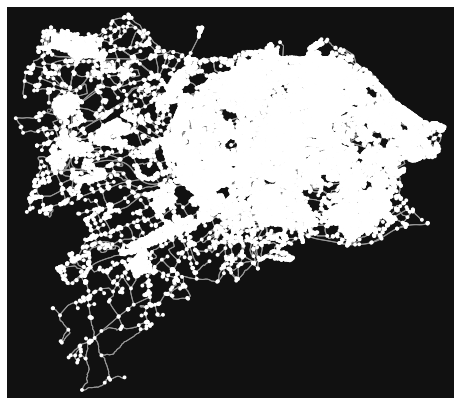

In [1]:
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
plt.style.use("dark_background")
%matplotlib inline

# Specify the name that is used to seach for the data
# place_name = "Bruntsfield, Edinburgh, Scotland"
place_name = "Edinburgh, Scotland"

# Fetch OSM street network from the location
graph = ox.graph_from_place(place_name)
# Plot the streets
fig, ax = ox.plot_graph(graph)

# Get some specific info from OSM

(The outdated queries in the course have been updated as per changelog here: https://github.com/gboeing/osmnx/issues/526)

#### Bicycle lanes

As advised here: https://help.openstreetmap.org/questions/64879/get-all-bicycle-infrastructure-for-a-city

<blockquote>
To get all cycle infrastructure you will need to retrieve at least:
    <ul>
<li>all roads that have additional tags indicating cycle infrastructure (cycleway=lane and cycleway=track)</li>
<li>all highway=cycleway</li>
<li>all highway=footway and highway=path that allow bicycle use or are intended for such (bicycle=yes, bicycle=designated, bicycle=official)</li>
    </ul>
</blockquote>

In [2]:
import numpy as np

tags={'highway':True}
highways = ox.geometries_from_place(place_name, tags)

bicycle_filters = []

for column in ['cycleway', 'cycleway:left', 'cycleway:right', 'cycleway:both']:
    if column not in highways.columns: continue
    bicycle_filters.append(highways[column]=='lane')

bicycle_filters.append(highways['highway']=='cycleway')
bicycle_filters.append(highways['bicycle']=='designated')
bicycle_filters=np.array(bicycle_filters)
bicycle_filters=np.any(bicycle_filters, axis=0)

#### Bicycle rentals

In [3]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from pyproj import CRS

df_stations = pd.read_csv('df_stations.csv')
df_stations['geometry'] = df_stations[['station_lon','station_lat']].apply(lambda x : Point(*x), axis=1)
df_stations=gpd.GeoDataFrame(df_stations)
df_stations.crs = CRS.from_epsg(4326)

In [4]:
# Get the bike rentals in the specific neighbourhood we are looking at now
tags = {'amenity':'bicycle_rental'}
bike_stations = ox.geometries_from_place(place_name, tags)

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


In [5]:
nodes, edges = ox.graph_to_gdfs(graph)

In [8]:
from pyproj import CRS

# Set projection
projection = CRS.from_epsg(3067)

# Re-project layer
edges = edges.to_crs(projection)
highways = highways.to_crs(projection)
bike_stations = bike_stations.to_crs(projection)
df_stations = df_stations.to_crs(projection)

# Path from a bike rental to the next

Let's see if we can plot a trip from one station to the next.

Now we will need some sort of metric system; therefore we need to project our graph: As the data is in WGS84 format, we should first reproject our data into a metric system. We can re-project the graph from latitudes and longitudes to an appropriate UTM zone:

In [9]:
graph_proj = ox.project_graph(graph)

# Get Edges and Nodes
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)
# Project the bike stations int our dataset in the same coordinates system
bike_stations_proj = bike_stations.to_crs(nodes_proj.crs)
# Project all bike stations in the same coordinates system
df_stations_proj = df_stations.to_crs(nodes_proj.crs)
# Project all the driveways in the same coordinates system
highways_proj = highways.to_crs(nodes_proj.crs)

print("Coordinate system:", edges_proj.crs)

Coordinate system: +proj=utm +zone=30 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs


# Map a bike factor through Edinburgh

### Map each bicycle rental in the Just Eat Dataset to its equivalent in the OSM data

In [10]:
def find_closest(p, df):
    return df.loc[df.geometry.apply(lambda x : x.distance(p)).idxmin()].station_id

bike_stations_proj['JustEat_id'] = bike_stations_proj.geometry.apply(lambda p : find_closest(p, df_stations_proj))

In [11]:
factor_trips = pd.read_csv('factor_trips.csv')[['start_station_id', 'end_station_id', 'intensity']]

filter_1 = factor_trips.start_station_id.isin(bike_stations_proj.JustEat_id)
filter_2 = factor_trips.end_station_id.isin(bike_stations_proj.JustEat_id)

factor_trips = factor_trips[filter_1 & filter_2]

JustEat_coords = bike_stations_proj.set_index('JustEat_id').geometry.to_dict()

factor_trips['start_geo'] = factor_trips.start_station_id.apply(lambda x : JustEat_coords[x])
factor_trips['end_geo'] = factor_trips.end_station_id.apply(lambda x : JustEat_coords[x])

factor_trips.intensity = factor_trips.intensity/factor_trips.intensity.max()

factor_trips = gpd.GeoDataFrame(factor_trips)

In [ ]:
# Precious help from: https://stackoverflow.com/questions/25408393/getting-individual-colors-from-a-color-map-in-matplotlib
import matplotlib

routes=[]
rc=[]
i=0
# Many of the parafac components are almost 0; they are not the interesting ones to us. We want to keep the few strong components,
# That hopefully make this factor disctinctive, so we want to set an intensity threshold under which we won't consider a component of
# the factor.
threshold = .01

factor_trips_toplot = factor_trips[factor_trips.intensity>=threshold].copy()
print(len(factor_trips_toplot), 'routes to plot')
for r in factor_trips_toplot.iterrows():
    row = r[1]
        
    orig_node = ox.distance.nearest_nodes(graph_proj, *row.start_geo.xy)
    target_node = ox.distance.nearest_nodes(graph_proj, *row.end_geo.xy)
    
    routes.append(nx.shortest_path(G=graph_proj, 
                             source=orig_node[0],
                             target=target_node[0],
                             weight='length'))
    
    color = '#%02x%02x%02x' % cmap(row.intensity, bytes=True)[:-1]
    rc.append(color)
    i+=1
    if i%10==0: print(i)

In [ ]:
# Keep only the nodes involved in our parallel factor
route_nodes = list(set(sum(routes, [])))

nodes_parafac = nodes_proj.loc[route_nodes]

#route_node_filter = lambda df, lvl : df.index.get_level_values(lvl).isin(route_nodes)
#edges_parafac = edges_proj[route_node_filter(edges_proj, 0) & route_node_filter(edges_proj, 1)]
def edges_from_route(route):
    return [(route[i], route[i+1]) for i in range (len(route)-1)]

edges_in_routes = sum([edges_from_route(route) for route in routes], [])

intensities = []

for route, intensity in zip(routes, factor_trips.intensity.values):
    for r in route:
        intensities.append(intensity)

df_edge_intensity = pd.DataFrame([[e[0], e[1], i] for e,i in zip(edges_in_routes, intensities)], columns=['u', 'v', 'i'])
df_edge_intensity = df_edge_intensity.groupby(['u', 'v']).sum()

In [ ]:
edges_parafac = edges_proj.reset_index(level=2).copy()
edges_parafac['intensity'] = df_edge_intensity['i']
edges_parafac = edges_parafac.loc[edges_in_routes]
edges_parafac.reset_index(inplace=True)
edges_parafac.set_index(['u', 'v', 'key'], inplace=True)
edges_parafac = edges_parafac[~edges_parafac.index.duplicated(keep='first')]

In [ ]:
edges_parafac.intensity.sort_values().plot()
plt.axhline(.05)

edges_parafac=edges_parafac[edges_parafac.intensity>.05]

In [ ]:
if set(nodes_parafac.index.unique()) == set(edges_parafac.index.get_level_values(0).unique()):
    print('nodes and edges have the same index')

graph_parafac = ox.graph_from_gdfs(nodes_parafac, edges_parafac)

In [ ]:
cmap = matplotlib.cm.get_cmap('hot')
#cmap = matplotlib.cm.get_cmap('plasma')

rc=[]
for i in edges_parafac.intensity/edges_parafac.intensity.max():
    rc.append('#%02x%02x%02x' % cmap(i, bytes=True)[:-1])

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
fig.patch.set_alpha(0)
gdf.plot(ax=ax, edgecolor='w', color='azure', alpha=.5, zorder=-2)
highways_proj.loc['way'][highways_proj.loc['way'].highway.isin(['primary', 'secondary', 'tertiary'])].plot(edgecolor='w', 
                                                                                                           ax=ax, zorder=-1,
                                                                                                          alpha=.8, lw=1)

ox.plot_graph(graph_parafac, node_size=0, edge_color=rc,
              show=False, close=False, ax=ax, edge_linewidth=1)
plt.axis('off')
plt.xlim(min(p.exterior.xy[0]), max(p.exterior.xy[0]))
plt.ylim(min(p.exterior.xy[1]), max(p.exterior.xy[1]))

plt.show()

In [36]:
def plot_factor(factor_file = 'Factors/factor_trips_0.csv', use_threshold=True, nth_strongest=20):
    """
    use_threshold : bool; only plot the most intense components of the factor
    nth_strongest : int; plot the components having intensity >= intensity(nth_strongest),
    """
    
    gdf = ox.geocode_to_gdf({'city': 'Edinburgh'})
    gdf = gdf.to_crs(nodes_proj.crs)
    
    factor_trips = pd.read_csv(factor_file)[['start_station_id', 'end_station_id', 'intensity']]

    filter_1 = factor_trips.start_station_id.isin(bike_stations_proj.JustEat_id)
    filter_2 = factor_trips.end_station_id.isin(bike_stations_proj.JustEat_id)

    factor_trips = factor_trips[filter_1 & filter_2]

    JustEat_coords = bike_stations_proj.set_index('JustEat_id').geometry.to_dict()

    factor_trips['start_geo'] = factor_trips.start_station_id.apply(lambda x : JustEat_coords[x])
    factor_trips['end_geo'] = factor_trips.end_station_id.apply(lambda x : JustEat_coords[x])

    factor_trips.intensity = factor_trips.intensity/factor_trips.intensity.max()

    factor_trips = gpd.GeoDataFrame(factor_trips)
    

    routes=[]
    # Many of the parafac components are almost 0; they are not the interesting ones to us. We want to keep the few strong components,
    # That hopefully make this factor disctinctive, so we want to set an intensity threshold under which we won't consider a component of
    # the factor.
    if use_threshold:
        # To set in a better way
        threshold = factor_trips.intensity.sort_values(ascending=False).values[nth_strongest]
        factor_trips_toplot = factor_trips[factor_trips.intensity>=threshold].copy()
    else:
        factor_trips_toplot = factor_trips.copy()
        
    print(len(factor_trips_toplot), 'routes to plot')
    for r in factor_trips_toplot.iterrows():
        row = r[1]

        orig_node = ox.distance.nearest_nodes(graph_proj, *row.start_geo.xy)
        target_node = ox.distance.nearest_nodes(graph_proj, *row.end_geo.xy)

        routes.append(nx.shortest_path(G=graph_proj, 
                                 source=orig_node[0],
                                 target=target_node[0],
                                 weight='length'))

    # Keep only the nodes involved in our parallel factor
    route_nodes = list(set(sum(routes, [])))

    nodes_parafac = nodes_proj.loc[route_nodes]

    #route_node_filter = lambda df, lvl : df.index.get_level_values(lvl).isin(route_nodes)
    #edges_parafac = edges_proj[route_node_filter(edges_proj, 0) & route_node_filter(edges_proj, 1)]
    def edges_from_route(route):
        return [(route[i], route[i+1]) for i in range (len(route)-1)]

    edges_in_routes = sum([edges_from_route(route) for route in routes], [])

    intensities = []

    for route, intensity in zip(routes, factor_trips.intensity.values):
        for r in route:
            intensities.append(intensity)

    df_edge_intensity = pd.DataFrame([[e[0], e[1], i] for e,i in zip(edges_in_routes, intensities)], columns=['u', 'v', 'i'])
    df_edge_intensity = df_edge_intensity.groupby(['u', 'v']).sum()
    
    edges_parafac = edges_proj.reset_index(level=2).copy()
    edges_parafac['intensity'] = df_edge_intensity['i']
    edges_parafac = edges_parafac.loc[edges_in_routes]
    edges_parafac.reset_index(inplace=True)
    edges_parafac.set_index(['u', 'v', 'key'], inplace=True)
    edges_parafac = edges_parafac[~edges_parafac.index.duplicated(keep='first')]
    
    # Problematic. Need to set the thresold in a more consistent way
    # edges_parafac=edges_parafac[edges_parafac.intensity>threshold]
    
    if set(nodes_parafac.index.unique()) == set(edges_parafac.index.get_level_values(0).unique()):
        print('nodes and edges have the same index')

    graph_parafac = ox.graph_from_gdfs(nodes_parafac, edges_parafac)
    
    cmap = matplotlib.cm.get_cmap('hot')
    #cmap = matplotlib.cm.get_cmap('plasma')

    rc=[]
    for i in edges_parafac.intensity/edges_parafac.intensity.max():
        rc.append('#%02x%02x%02x' % cmap(i, bytes=True)[:-1])
        
    fig, ax = plt.subplots(figsize=(8,8))
    fig.patch.set_alpha(0)
    
    gdf.plot(ax=ax, edgecolor='w', color='azure', alpha=.5, zorder=-2)
    
    highways_proj.loc['way'][highways_proj.loc['way'].highway.isin(['primary', 'secondary', 'tertiary'])].plot(edgecolor='w', 
                                                                                                               ax=ax, zorder=-1,
                                                                                                              alpha=.8, lw=1)

    ox.plot_graph(graph_parafac, node_size=0, edge_color=rc,
                  show=False, close=False, ax=ax, edge_linewidth=1)
    plt.axis('off')
    
    p=gdf.geometry[0]
    plt.xlim(min(p.exterior.xy[0]), max(p.exterior.xy[0]))
    plt.ylim(min(p.exterior.xy[1]), max(p.exterior.xy[1]))
    
    plt.show()
    
def plot_factor_temporal(t):
    
    fig, ax = plt.subplots(figsize=(8,3))
    fig.patch.set_alpha(0)
    df_t = pd.read_csv(t)
    df_t.H_intensity.plot(ax=ax)
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.show()

In [37]:
import os 
import matplotlib

spatial_components = sorted(['Factors/' + n for n in os.listdir('Factors') if 'trips' in n])
temporal_components = sorted(['Factors/' + n for n in os.listdir('Factors') if 'temporality' in n])

21 routes to plot


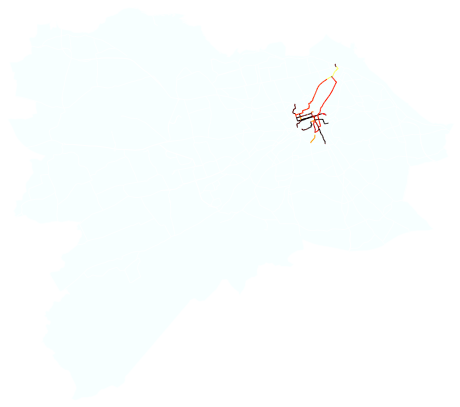

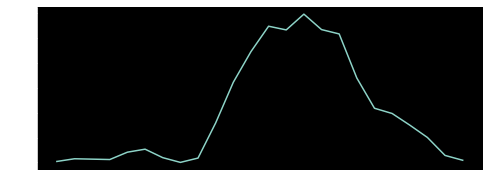

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


21 routes to plot


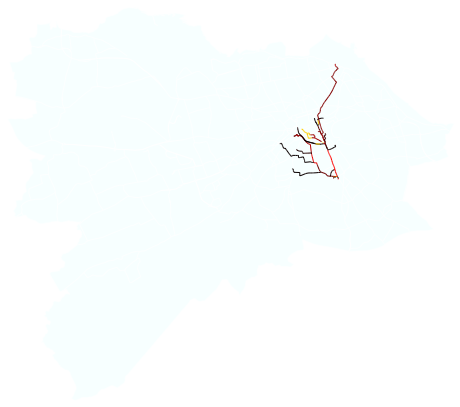

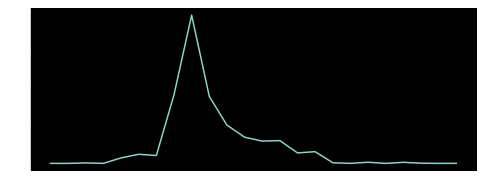

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


21 routes to plot


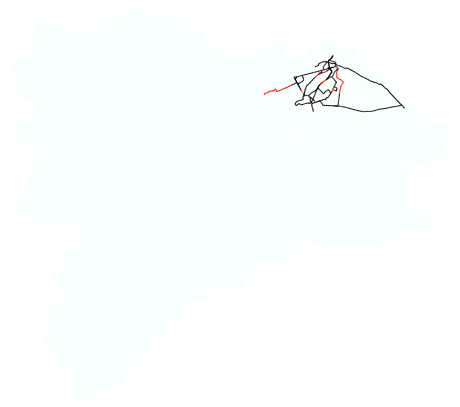

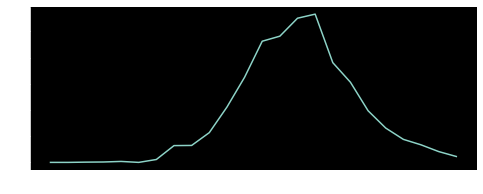

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


21 routes to plot


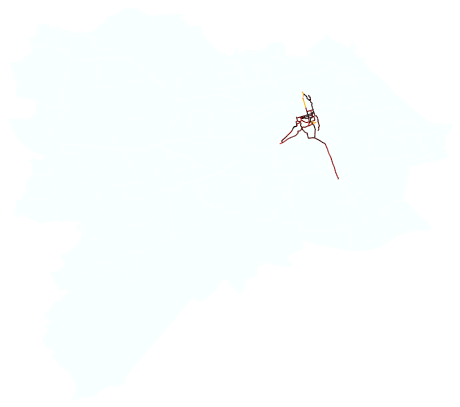

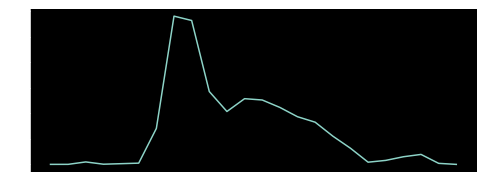

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


21 routes to plot


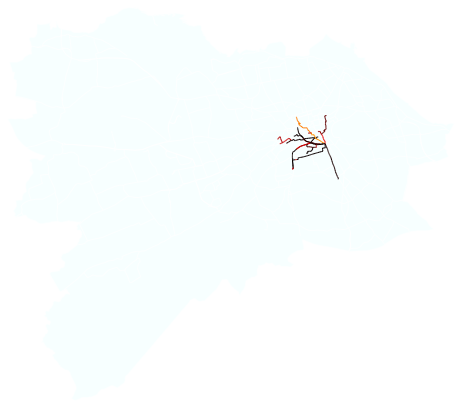

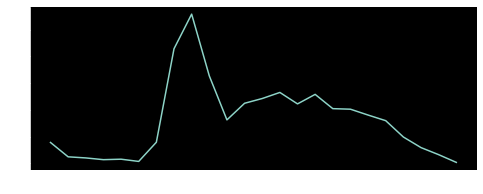

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


21 routes to plot


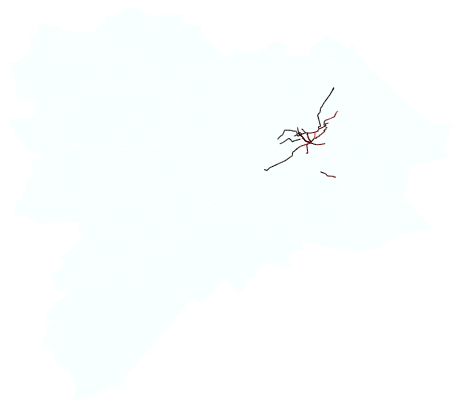

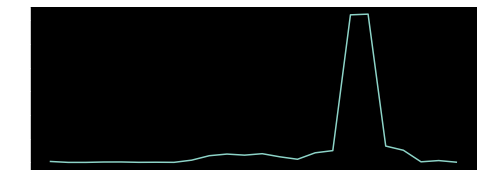

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


21 routes to plot


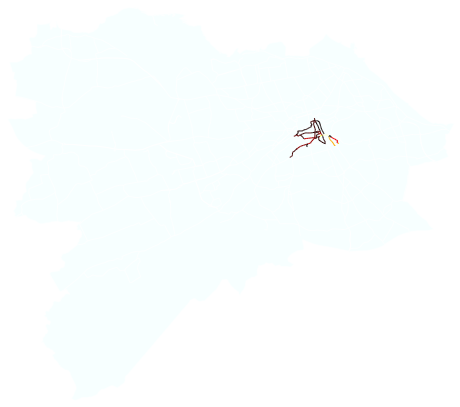

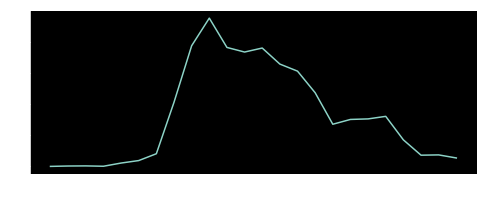

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


21 routes to plot


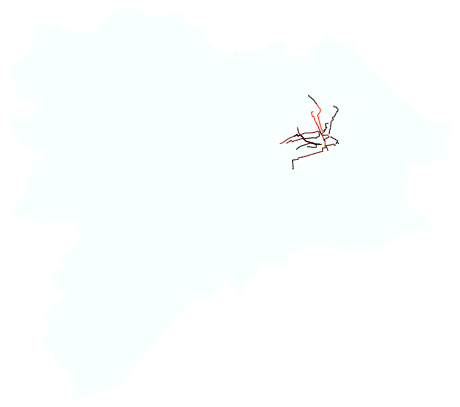

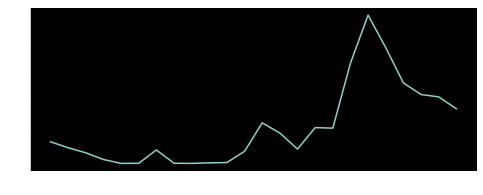

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


21 routes to plot


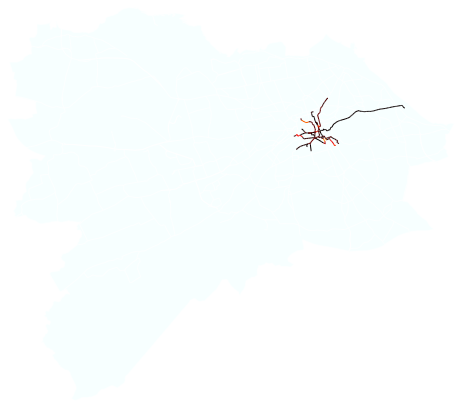

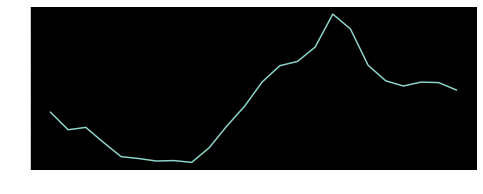

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


21 routes to plot


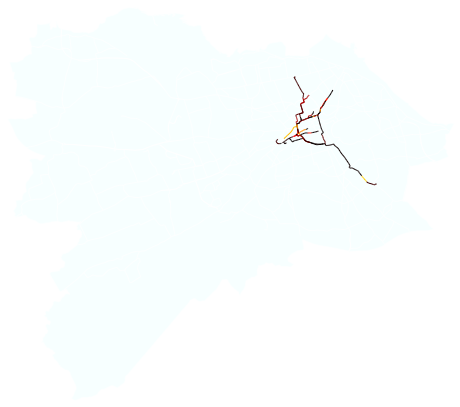

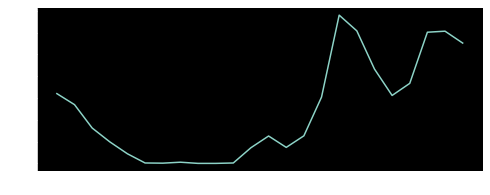

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


21 routes to plot


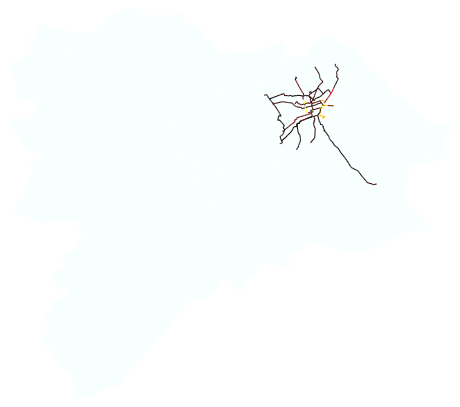

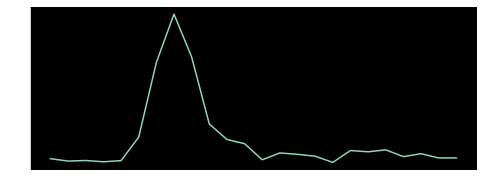

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


21 routes to plot


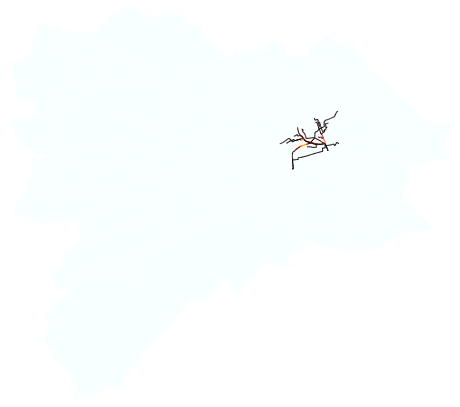

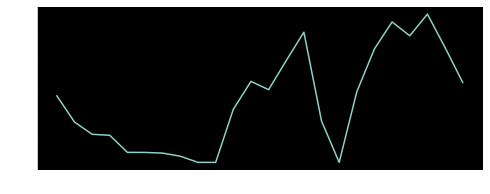

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


21 routes to plot


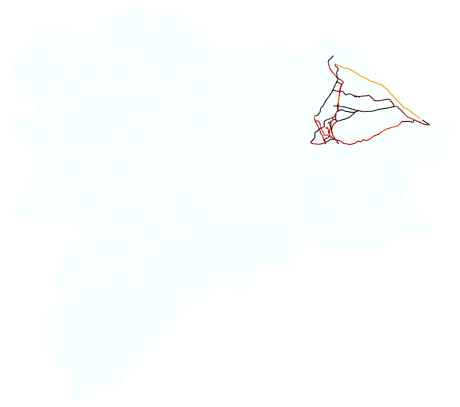

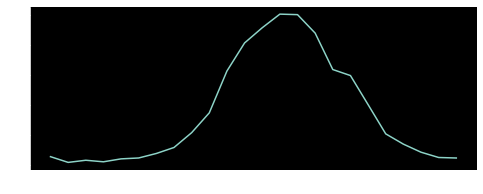

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


21 routes to plot


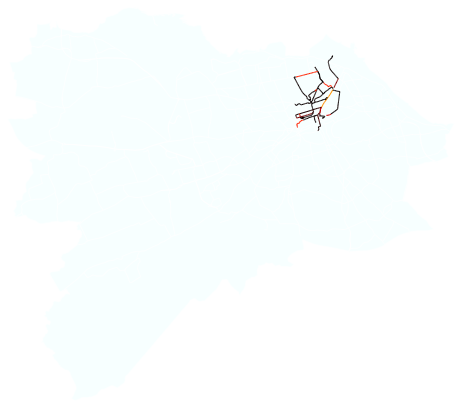

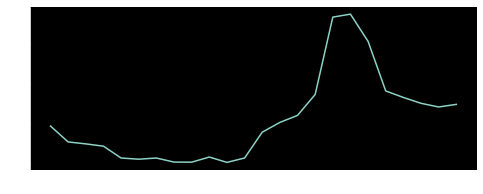

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


21 routes to plot


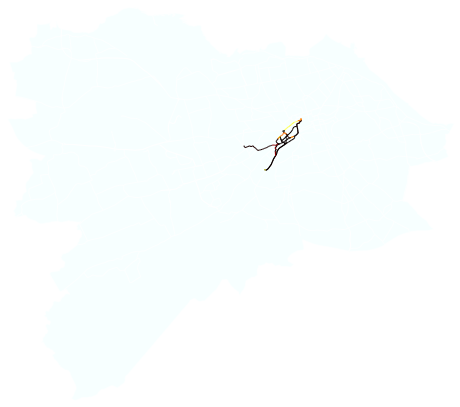

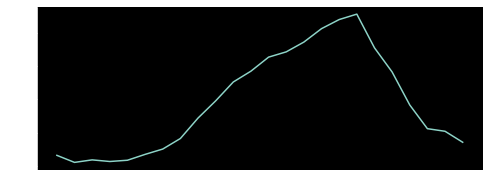

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


21 routes to plot


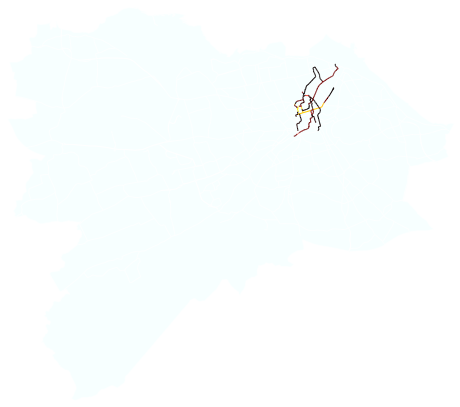

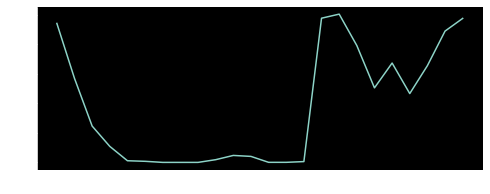

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


21 routes to plot


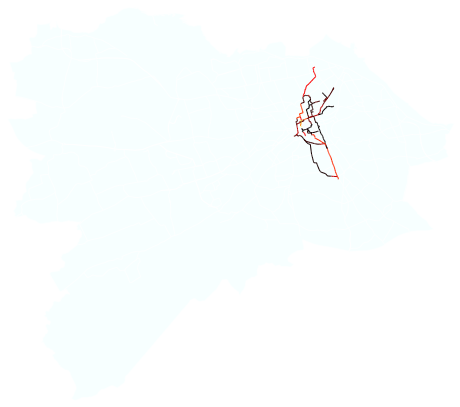

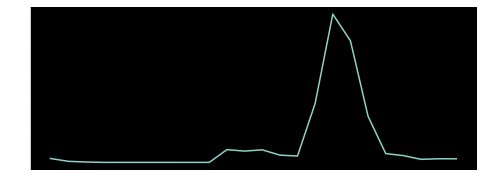

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


21 routes to plot


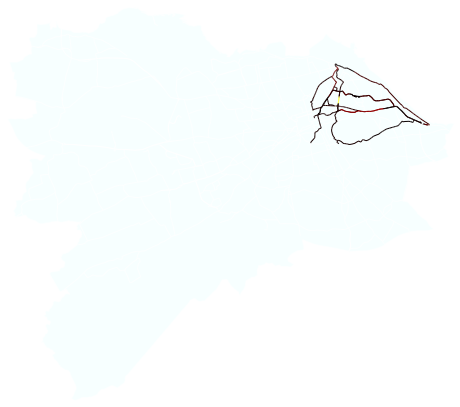

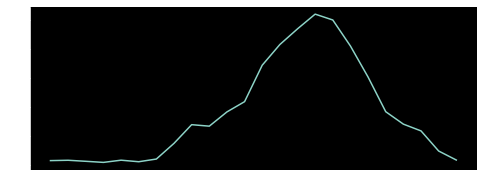

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


21 routes to plot


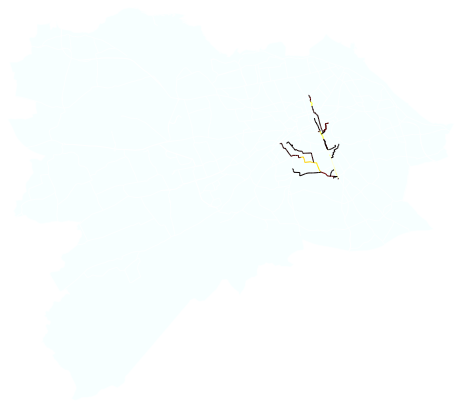

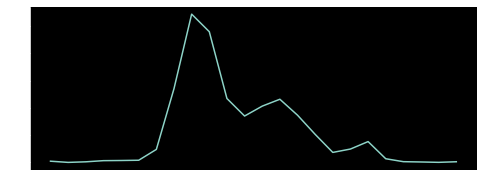

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


21 routes to plot


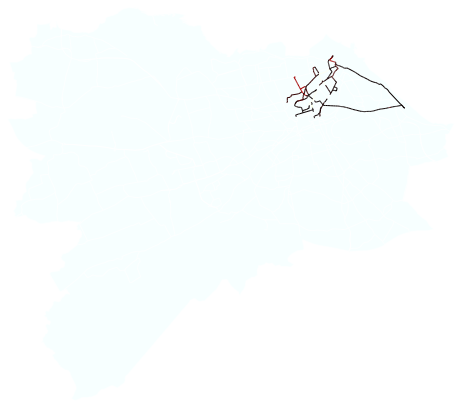

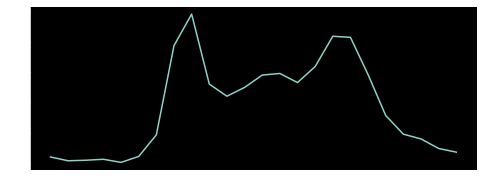

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


21 routes to plot


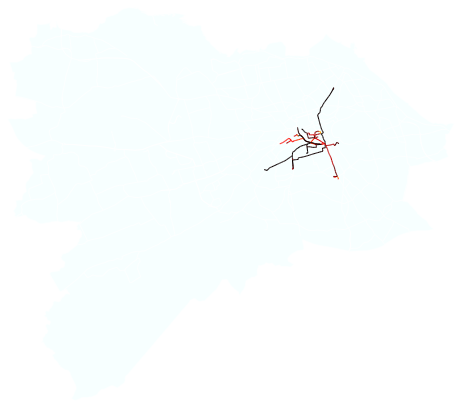

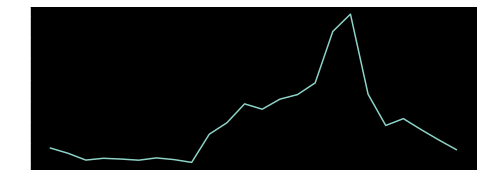

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


21 routes to plot


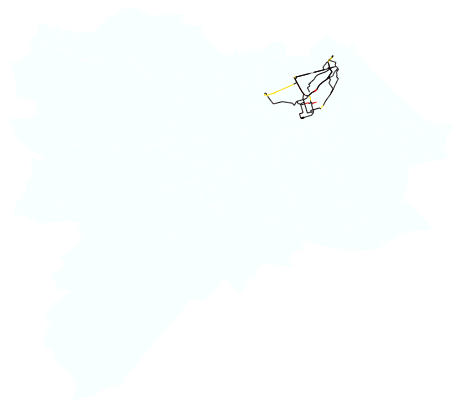

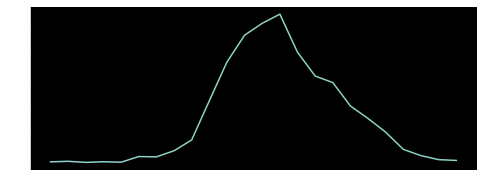

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


21 routes to plot


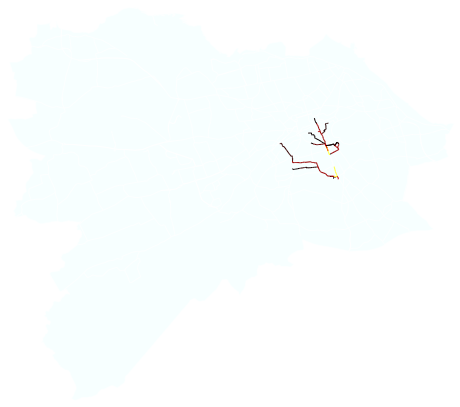

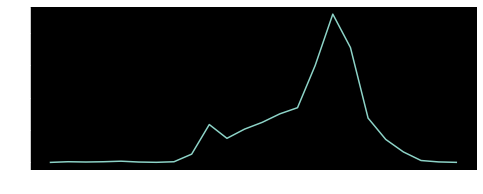

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


21 routes to plot


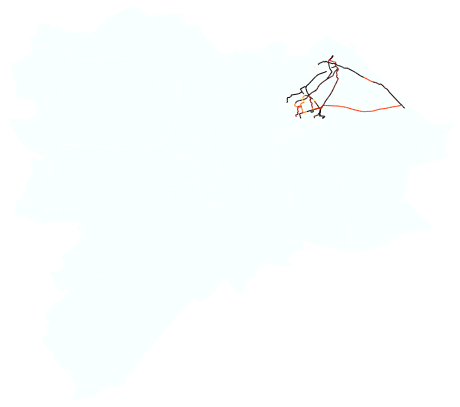

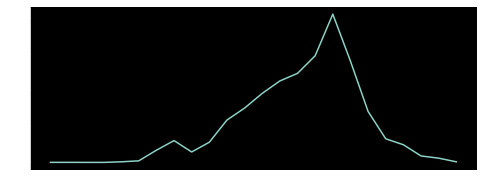

In [38]:
for s,t in zip(spatial_components,temporal_components):
    plot_factor(s)
    plot_factor_temporal(t)